In [610]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError
from tensorflow.keras.utils import plot_model

In [611]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [612]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [613]:
image_dataset_path = image_dest_path

In [614]:
csv_bounding_boxes = (f'{csv_path}\\PCB_annotations_dataset.csv')
images = os.listdir(image_dataset_path)

In [615]:
df = pd.read_csv(csv_bounding_boxes, sep=";")

In [616]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

image_data = []
class_labels = []
mask_data= []

grouped_bbox = bounding_boxes_data.groupby('filename')

In [617]:
image_data = []
mask_data = []
class_labels = []

for filename in images:
   
    image_path = os.path.join(image_dataset_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['defect']
        
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            #mask_color = class_to_color[class_label]
            mask[ymin:ymax, xmin:xmax] = 1 #mask_color 
    
        
    mask_data.append(mask)
    
    class_labels.append(class_label)

X_images = np.array(image_data)
y_bounding_boxes = np.array(mask_data)
y_class_labels = np.array(class_labels)

# class_label_mapping = {label: index for index, label in enumerate(np.unique(class_labels))}
# y_class_labels_numeric = np.array([class_label_mapping[label] for label in class_labels])

# num_classes = len(class_label_mapping)
# y_categorical = to_categorical(y_class_labels_numeric, num_classes=num_classes)


In [618]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(y_class_labels.shape)

(600, 600, 600)
(600, 600, 600)
(600,)


In [619]:
unique_labels, label_counts = np.unique(y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 100
Label: mouse_bite, Count: 100
Label: open_circuit, Count: 100
Label: short, Count: 100
Label: spur, Count: 100
Label: spurious_copper, Count: 100


In [620]:
new_size = (200, 200)

def crop_images(X_images, y_bounding_boxes, y_class_labels, new_size):
    if not all(new < orig and orig % new == 0 for orig, new in zip((600, 600), new_size)):
        print("New size must be smaller and a divisor of the original size.")
        return False
    
    cropped_images_int = []
    cropped_masks_int = []
    cropped_y_class_labels_int = []

    for image, mask, labels in zip(X_images, y_bounding_boxes, y_class_labels):
        for y in range(0, 600, new_size[0]):
            for x in range(0, 600, new_size[0]):
                y0, x0 = y, x
                y_new_size, x_new_size = y+new_size[0], x+new_size[0]
                # if a bounding box crosses the cropping border, shift the corresponding border, so defects are not cut off
                while( np.any(mask[y0, x0:x_new_size])) and (y0 != 0): 
                    y0 -= 1
                while (np.any(mask[min(y_new_size, 599), x0:x_new_size])) and (y_new_size != 600):
                    y_new_size += 1
                while( np.any(mask[y0:y_new_size, x0])) and (x0 != 0):
                    x0 -= 1
                while( np.any(mask[y0:y_new_size, min(x_new_size, 599)])) and (x_new_size != 600):
                    x_new_size += 1
                patch_image = cv2.resize(image[y0:y_new_size, x0:x_new_size], new_size)
                patch_mask = cv2.resize(mask[y0:y_new_size, x0:x_new_size], new_size)
                
                #patch_image = image[y:y+new_size[0], x:x+new_size[0]]
                #patch_mask = mask[y:y+new_size[0], x:x+new_size[0]]

                if np.sum(patch_mask) > threshold:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append(labels)
                else:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append("none")

    cropped_images = np.array(cropped_images_int)
    cropped_masks = np.array(cropped_masks_int)
    cropped_y_class_labels = np.array(cropped_y_class_labels_int)
    return cropped_images, cropped_masks, cropped_y_class_labels

cropped_images, cropped_masks, cropped_y_class_labels = crop_images(X_images, y_bounding_boxes, y_class_labels, new_size)

print(cropped_images.shape)
print(cropped_masks.shape)
print(cropped_y_class_labels.shape)

(5400, 200, 200)
(5400, 200, 200)
(5400,)


In [621]:
unique_labels, label_counts = np.unique(cropped_y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 219
Label: mouse_bite, Count: 223
Label: none, Count: 4054
Label: open_circuit, Count: 203
Label: short, Count: 222
Label: spur, Count: 245
Label: spurious_copper, Count: 234


In [646]:
def plot_images(images, masks, labels, num_samples=6):
    _ , axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.ravel()
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].imshow(masks[idx], alpha=0.5, cmap='jet')
        axes[i].set_title(f'Label: {labels[idx]} {idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



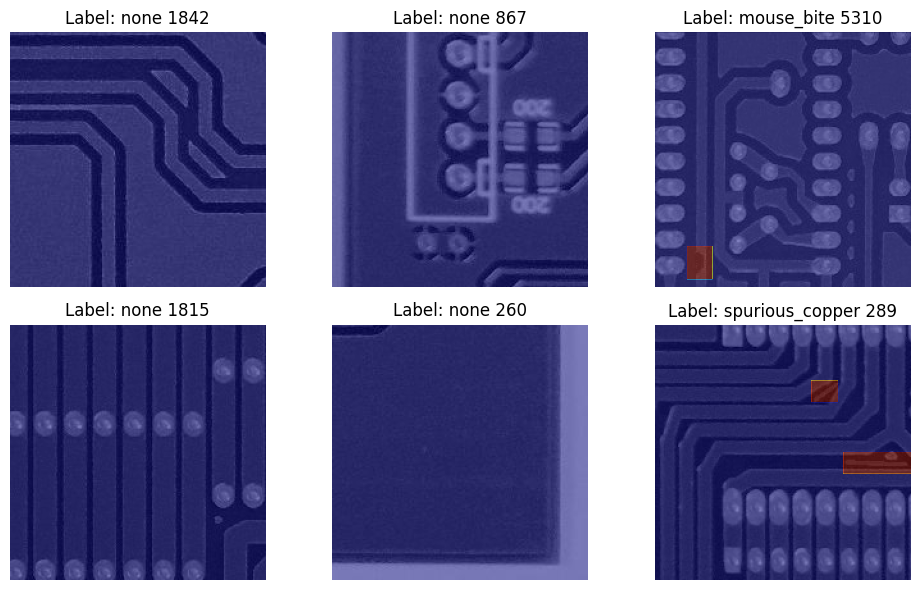

In [665]:
# Plot random 6 images
plot_images(cropped_images, cropped_masks, cropped_y_class_labels)

In [678]:

def separate_defects(original_images, mask_images, class_labels):
    separated_images = []
    separated_masks = []
    separated_labels = []

    for idx, (original_image, mask_image, class_label) in enumerate(zip(original_images, mask_images, class_labels)):
        contours, _ = cv2.findContours(mask_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(f"Processing Image {idx+1}")
        # print(f"Found {len(contours)} contours in image {idx+1}")
        if len(contours) > 1:
            #print(f"Image {idx+1}: Found {len(contours)} contours.")
            for contour_idx, contour in enumerate(contours):
                # print(f"Processing Contour {contour_idx+1} of {len(contours)}")
                all_contours_mask = np.zeros_like(mask_image)
                cv2.drawContours(all_contours_mask, [contour], -1, 255, -1)

                exclude_other_contours_mask = np.zeros_like(mask_image)
                cv2.drawContours(exclude_other_contours_mask, contours, -1, 255, -1)
                exclude_other_contours_mask = cv2.bitwise_xor(all_contours_mask, exclude_other_contours_mask)

                new_image = original_image.copy()
                new_mask = mask_image.copy()

                new_image[exclude_other_contours_mask == 255] = 0
                new_mask[exclude_other_contours_mask == 255] = 0

                separated_images.append(new_image)
                separated_masks.append(new_mask)
                separated_labels.append(class_label)

                '''
                # Debug print to confirm the processing of each contour
                print(f"Processed contour {contour_idx+1} for image {idx+1}")
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(new_image, cmap='gray')
                plt.title(f"Image {idx+1} Contour {contour_idx+1}")
                plt.subplot(1, 2, 2)
                plt.imshow(new_mask, cmap='gray')
                plt.title(f"Mask {idx+1} Contour {contour_idx+1}")
                plt.show()
                '''

        else:
            separated_images.append(original_image.copy())
            separated_masks.append(mask_image.copy())
            separated_labels.append(class_label)
            # print(f"Image {idx+1} has {len(contours)} contours, appending original.")
                                        
    return separated_images, separated_masks, separated_labels

separated_images, separated_masks, separated_labels = separate_defects(cropped_images, cropped_masks, cropped_y_class_labels)


In [679]:
separated_images_array = np.asarray(separated_images)
separated_masks_array = np.asarray(separated_masks)
separated_labels_array = np.asarray(separated_labels)

print(separated_images_array.shape)
print(separated_masks_array.shape)
print(separated_labels_array.shape)

(5568, 200, 200)
(5568, 200, 200)
(5568,)


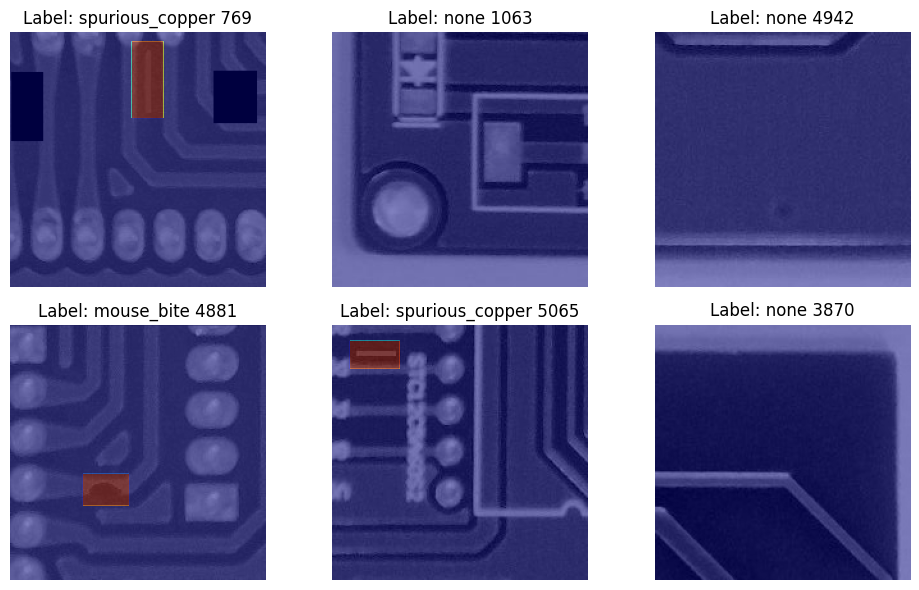

In [703]:
if separated_images:
    plot_images(separated_images_array, separated_masks_array, separated_labels_array)
else:
    print("No separated images found.")

In [704]:
unique_labels, label_counts = np.unique(separated_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 231
Label: mouse_bite, Count: 242
Label: none, Count: 4054
Label: open_circuit, Count: 228
Label: short, Count: 259
Label: spur, Count: 282
Label: spurious_copper, Count: 272


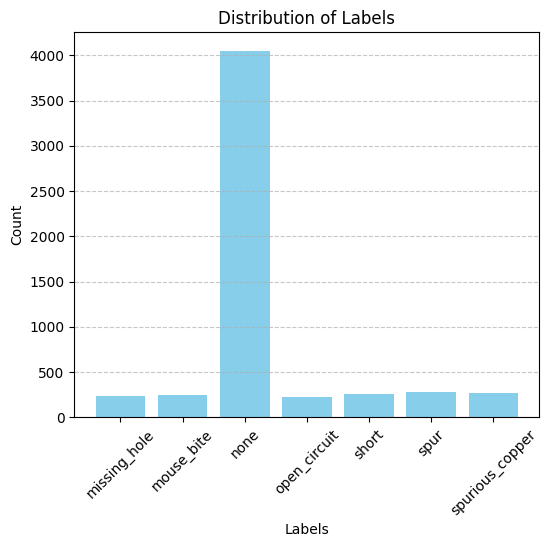

In [705]:
plt.figure(figsize=(6, 5))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

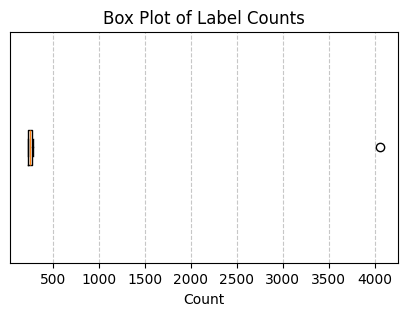

In [706]:
plt.figure(figsize=(5, 3))
plt.boxplot(label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The above distribution of data is clearly unbalanced, so we need to balance out the data by introducing more images to even out the distribution or to delete some data.

In [707]:
max_samples_per_class = 200

In [708]:
label_counts = defaultdict(int)

# Count the occurrences of each label
for label in separated_labels_array:
    label_counts[label] += 1

# Filter out extra samples for each class label
filtered_images = []
filtered_masks = []
filtered_labels = []

for label in set(separated_labels_array):
    label_indices = [i for i, l in enumerate(separated_labels_array) if l == label]
    if len(label_indices) > max_samples_per_class:
        selected_indices = random.sample(label_indices, max_samples_per_class)
    else:
        selected_indices = label_indices
    filtered_images.extend(separated_images_array[selected_indices])
    filtered_masks.extend(separated_masks_array[selected_indices])
    filtered_labels.extend(separated_labels_array[selected_indices])

# Convert the filtered lists to arrays
filtered_images = np.array(filtered_images)
filtered_masks = np.array(filtered_masks)
filtered_labels = np.array(filtered_labels)

In [709]:
# Print the shape of filtered data
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Masks Shape:", filtered_masks.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (1400, 200, 200)
Filtered Masks Shape: (1400, 200, 200)
Filtered Labels Shape: (1400,)


In [710]:
filtered_unique_labels, filtered_label_counts = np.unique(filtered_labels, return_counts=True)

for label, count in zip(filtered_unique_labels, filtered_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 200
Label: mouse_bite, Count: 200
Label: none, Count: 200
Label: open_circuit, Count: 200
Label: short, Count: 200
Label: spur, Count: 200
Label: spurious_copper, Count: 200


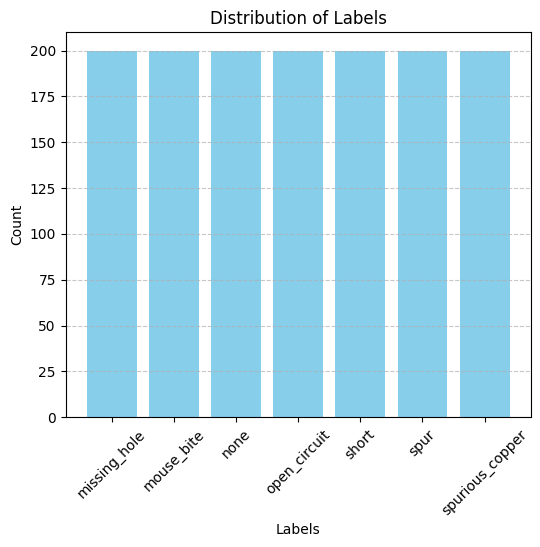

In [711]:
plt.figure(figsize=(6, 5))
plt.bar(filtered_unique_labels, filtered_label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

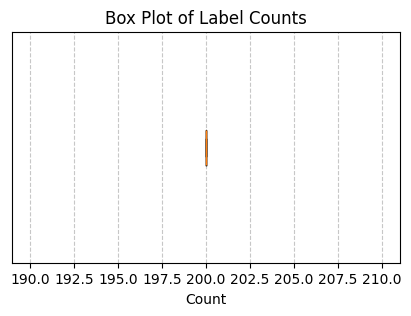

In [712]:
plt.figure(figsize=(5, 3))
plt.boxplot(filtered_label_counts, vert=False)
plt.yticks([])
plt.xlabel('Count')
plt.title('Box Plot of Label Counts')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

After including more images (along with the coresponding masks and labels) and deleting surplus data, the dataset is more balanced.

In [713]:
for i, label in enumerate(filtered_labels):
    # Check if the label is "none"
    if label == "none":
        # Replace the corresponding mask image with a blank image
        filtered_masks[i] = np.zeros_like(filtered_masks[i])

In [714]:
encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(filtered_labels)
filtered_y_categorical = to_categorical(y_class_labels_encoded)

In [715]:
combined_data = []

combined_data = list(zip(filtered_images, filtered_masks, filtered_labels, filtered_y_categorical))

Labels: short


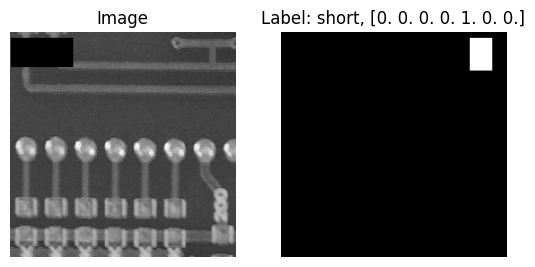

In [733]:
np.random.shuffle(combined_data)
for images, masks, labels, cat in combined_data:
    
    print("Labels:", labels)

    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    plt.title(f'Label: {labels}, {cat}') 

    plt.axis('off')
    plt.show()

    break 

In [734]:
print(filtered_images.shape)
print(filtered_masks.shape)
print(filtered_labels.shape)
print(filtered_y_categorical.shape)
print(filtered_label_counts.shape)

(1400, 200, 200)
(1400, 200, 200)
(1400,)
(1400, 7)
(7,)


In [735]:
# Split data into train and validation sets
X_train, X_test, y_train_mask, y_test_mask, y_train_class, y_test_class= train_test_split(filtered_images, filtered_masks, filtered_y_categorical, 
                                                                                                      test_size=0.2, random_state=42)

In [736]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_mask.shape)
print("y_train_categorical shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_bbox shape:", y_test_mask.shape)
print("y_test_categorical shape:", y_test_class.shape)

X_train shape: (1120, 200, 200)
y_train_bbox shape: (1120, 200, 200)
y_train_categorical shape: (1120, 7)
X_test shape: (280, 200, 200)
y_test_bbox shape: (280, 200, 200)
y_test_categorical shape: (280, 7)


In [739]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip
threshold = 100
none_label = np.array([0, 0, 1, 0, 0, 0, 0])
def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, labels in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(labels)

        shear_image, shear_mask = shear(image, mask)
        if np.sum(shear_mask) > threshold:
            augmented_images.append(shear_image)
            augmented_masks.append(shear_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(shear_image)
            augmented_masks.append(shear_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(shear_image)
        # augmented_masks.append(shear_mask)
        # augmented_labels.append(labels)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        if np.sum(flip_mask) > threshold:
            augmented_images.append(flip_image)
            augmented_masks.append(flip_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(flip_image)
            augmented_masks.append(flip_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(flip_image)
        # augmented_masks.append(flip_mask)
        # augmented_labels.append(labels)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        if np.sum(zoom_mask) > threshold:
            augmented_images.append(zoom_image)
            augmented_masks.append(zoom_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(zoom_image)
            augmented_masks.append(zoom_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(zoom_image)
        # augmented_masks.append(zoom_mask)
        # augmented_labels.append(labels)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        if np.sum(width_shift_mask) > threshold:
            augmented_images.append(width_shift_image)
            augmented_masks.append(width_shift_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(width_shift_image)
            augmented_masks.append(width_shift_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(width_shift_image)
        # augmented_masks.append(width_shift_mask)
        # augmented_labels.append(labels)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        if np.sum(height_shift_mask) > threshold:
            augmented_images.append(height_shift_image)
            augmented_masks.append(height_shift_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(height_shift_image)
            augmented_masks.append(height_shift_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(height_shift_image)
        # augmented_masks.append(height_shift_mask)
        # augmented_labels.append(labels)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        if np.sum(rotate_mask) > threshold:
            augmented_images.append(rotate_image)
            augmented_masks.append(rotate_mask)
            augmented_labels.append(labels)
        else:
            augmented_images.append(rotate_image)
            augmented_masks.append(rotate_mask)
            augmented_labels.append(none_label)
        # augmented_images.append(rotate_image)
        # augmented_masks.append(rotate_mask)
        # augmented_labels.append(labels)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros((new_size[0], new_size[0]), dtype=np.uint8)
    padded_mask = np.zeros((new_size[0], new_size[0]), dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < new_size[0] or cols < new_size[0]:
        pad_rows = max(0, (new_size[0] - rows) // 2)
        pad_cols = max(0, (new_size[0] - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, new_size[0] - rows - pad_rows, pad_cols, new_size[0] - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > new_size[0] or cols > new_size[0]:
        zoomed_image = zoomed_image[:new_size[0], :new_size[0]]
        zoomed_mask = zoomed_mask[:new_size[0], :new_size[0]]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > new_size[0]:
        width_shift_image = width_shift_image[:, :new_size[0]]
        width_shift_mask = width_shift_mask[:, :new_size[0]]
    elif width_shift_image.shape[1] < new_size[0]:
        pad_width = new_size[0] - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > new_size[0]:
        height_shift_image = height_shift_image[:new_size[0], :]
        height_shift_mask = height_shift_mask[:new_size[0], :]
    elif height_shift_image.shape[0] < new_size[0]:
        pad_height = new_size[0] - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > new_size[0] or rotate_image.shape[1] > new_size[0]:
        rotate_image = cv2.resize(rotate_image, (new_size[0], new_size[0]))
        rotate_mask = cv2.resize(rotate_mask, (new_size[0], new_size[0]))
    elif rotate_image.shape[0] < new_size[0] or rotate_image.shape[1] < new_size[0]:
        pad_height = max(0, new_size[0] - rotate_image.shape[0])
        pad_width = max(0, new_size[0] - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


In [740]:
X_train_augmented_int, y_train_mask_augmented_int, y_train_class_augmented_int = augment_data(X_train, y_train_mask, y_train_class)

In [741]:
for i, label in enumerate(y_train_class_augmented_int):
    # Check if the label is "none"
    if np.array_equal(label, [0, 0, 1, 0, 0, 0, 0]):
        # Replace the corresponding mask image with a blank image
        y_train_mask_augmented_int[i] = np.zeros_like(y_train_mask_augmented_int[i])

In [743]:
augmented_classes = np.argmax(y_train_class_augmented_int, axis=1)

In [744]:
y_train_unique_labels, y_train_label_counts = np.unique(augmented_classes, return_counts=True)

for label, count in zip(y_train_unique_labels, y_train_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1052
Label: 1, Count: 1072
Label: 2, Count: 1354
Label: 3, Count: 1065
Label: 4, Count: 1101
Label: 5, Count: 1061
Label: 6, Count: 1135


After data augmentation, more imbalance is introduced, we will offset this be minimizing our classes to 500 points of data per class.

In [745]:
max_samples_per_augmented_class = 1000

label_counts = defaultdict(int)

# Count the occurrences of each label
for label in augmented_classes:
    label_counts[label] += 1

# Filter out extra samples for each class label
x_train_filtered_images = []
y_train_filtered_mask = []
y_train_filtered_labels = []

for label in set(augmented_classes):
    label_indices = [i for i, l in enumerate(augmented_classes) if l == label]
    if len(label_indices) > max_samples_per_augmented_class:
        selected_indices = random.sample(label_indices, max_samples_per_augmented_class)
    else:
        selected_indices = label_indices
    x_train_filtered_images.extend(X_train_augmented_int[selected_indices])
    y_train_filtered_mask.extend(y_train_mask_augmented_int[selected_indices])
    y_train_filtered_labels.extend(y_train_class_augmented_int[selected_indices])

# Convert the filtered lists to arrays
x_train_filtered_images = np.array(x_train_filtered_images)
y_train_filtered_mask = np.array(y_train_filtered_mask)
y_train_filtered_labels = np.array(y_train_filtered_labels)

In [746]:
augmented_classes_filtered = np.argmax(y_train_filtered_labels, axis=1)

In [747]:
y_train_unique_labels, y_train_label_counts = np.unique(augmented_classes_filtered, return_counts=True)

for label, count in zip(y_train_unique_labels, y_train_label_counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 1, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 5, Count: 1000
Label: 6, Count: 1000


In [748]:
combined_data2 = []

combined_data2 = list(zip(x_train_filtered_images, y_train_filtered_mask, y_train_filtered_labels))

Labels: [0. 1. 0. 0. 0. 0. 0.]


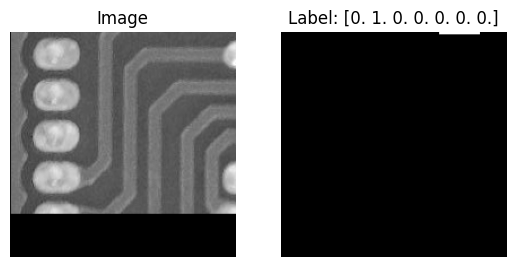

In [775]:
np.random.shuffle(combined_data2)
for images, masks, labels in combined_data2:
    
    print("Labels:", labels)

    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    plt.title(f'Label: {labels}') 

    plt.axis('off')
    plt.show()

    break 

In [776]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_mask.shape)
print("y_train_categorical shape:", y_train_class.shape)

print("X_train_augmented shape:", x_train_filtered_images.shape)
print("y_train_augmented shape:", y_train_filtered_mask.shape)
print("y_train_categorical_augmented shape:", y_train_filtered_labels.shape)

X_train shape: (1120, 200, 200)
y_train_bbox shape: (1120, 200, 200)
y_train_categorical shape: (1120, 7)
X_train_augmented shape: (7000, 200, 200)
y_train_augmented shape: (7000, 200, 200)
y_train_categorical_augmented shape: (7000, 7)


In [777]:
# to save the filtered, augmented dataset to disk
def save_data_to_disk(X, y_mask, y_class, filepath):
    with h5py.File(filepath, 'w') as hf:
        hf.create_dataset('X', data=X)
        hf.create_dataset('y_mask', data=y_mask)
        hf.create_dataset('y_class', data=y_class)

In [778]:
downloads_path = os.path.expanduser("~/Downloads")
file_name = "filtered_augmented_data.h5"
file_path = os.path.join(downloads_path, file_name)

save_data_to_disk(x_train_filtered_images, y_train_filtered_mask, y_train_filtered_labels, file_path)

Initializing functions for deep learning model

In [779]:
class TimingCallback(Callback):
    def __init__(self, max_duration_seconds, logs={}):
        self.logs=[]
        self.max_duration_seconds = max_duration_seconds
            
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        total_duration = timer() - self.start_time
        if total_duration > self.max_duration_seconds:
            print(f"Stopping training after {total_duration / 3600} hours")
            self.model.stop_training = True


In [780]:
early_stopping = EarlyStopping(
                                patience=10, 
                                min_delta = 0.005, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=10, 
                                    episilon= 0.005,
                                    factor=0.1,  
                                    cooldown = 4, 
                                    verbose=1)

time_callback = TimingCallback(10800)

In [781]:
def elegant_unet_segmentation_classification(input_shape, num_classes):
   
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom 
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    # Segmentation output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Classification head
    classification_flatten = layers.Flatten()(conv3)
    dense1 = layers.Dense(128, activation='relu')(classification_flatten)
    dropout = layers.Dropout(0.5)(dense1)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout)

    # Create model
    model = models.Model(inputs=inputs, outputs=[segmentation_output, classification_output])
    return model


In [782]:
num_classes=len(labels)
print(num_classes)

7


In [783]:
# Instantiate the model
model = elegant_unet_segmentation_classification(input_shape=(new_size[0], new_size[0], 1), num_classes=num_classes)

In [784]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'segmentation_output': 'binary_crossentropy',  # for the mask output with sigmoid 
        'classification_output': 'categorical_crossentropy'  # for the classification output with softmax
    },
    loss_weights={
        'segmentation_output': 0.6,  # Weighted at 70%
        'classification_output': 0.4  # Weighted at 30%
    },
    metrics={
        'segmentation_output': ['accuracy', MeanAbsoluteError()],  # Adding MAE for mask
        'classification_output': ['accuracy', Recall(), Precision()]  # Metrics for classification
    }
)

In [785]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 200,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 100,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 50, 50,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 50,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │      1,024 │ conv2d_6[0][0]  

 Total params: 84,378,952 (321.88 MB)

 Trainable params: 84,375,880 (321.87 MB)

 Non-trainable params: 3,072 (12.00 KB)

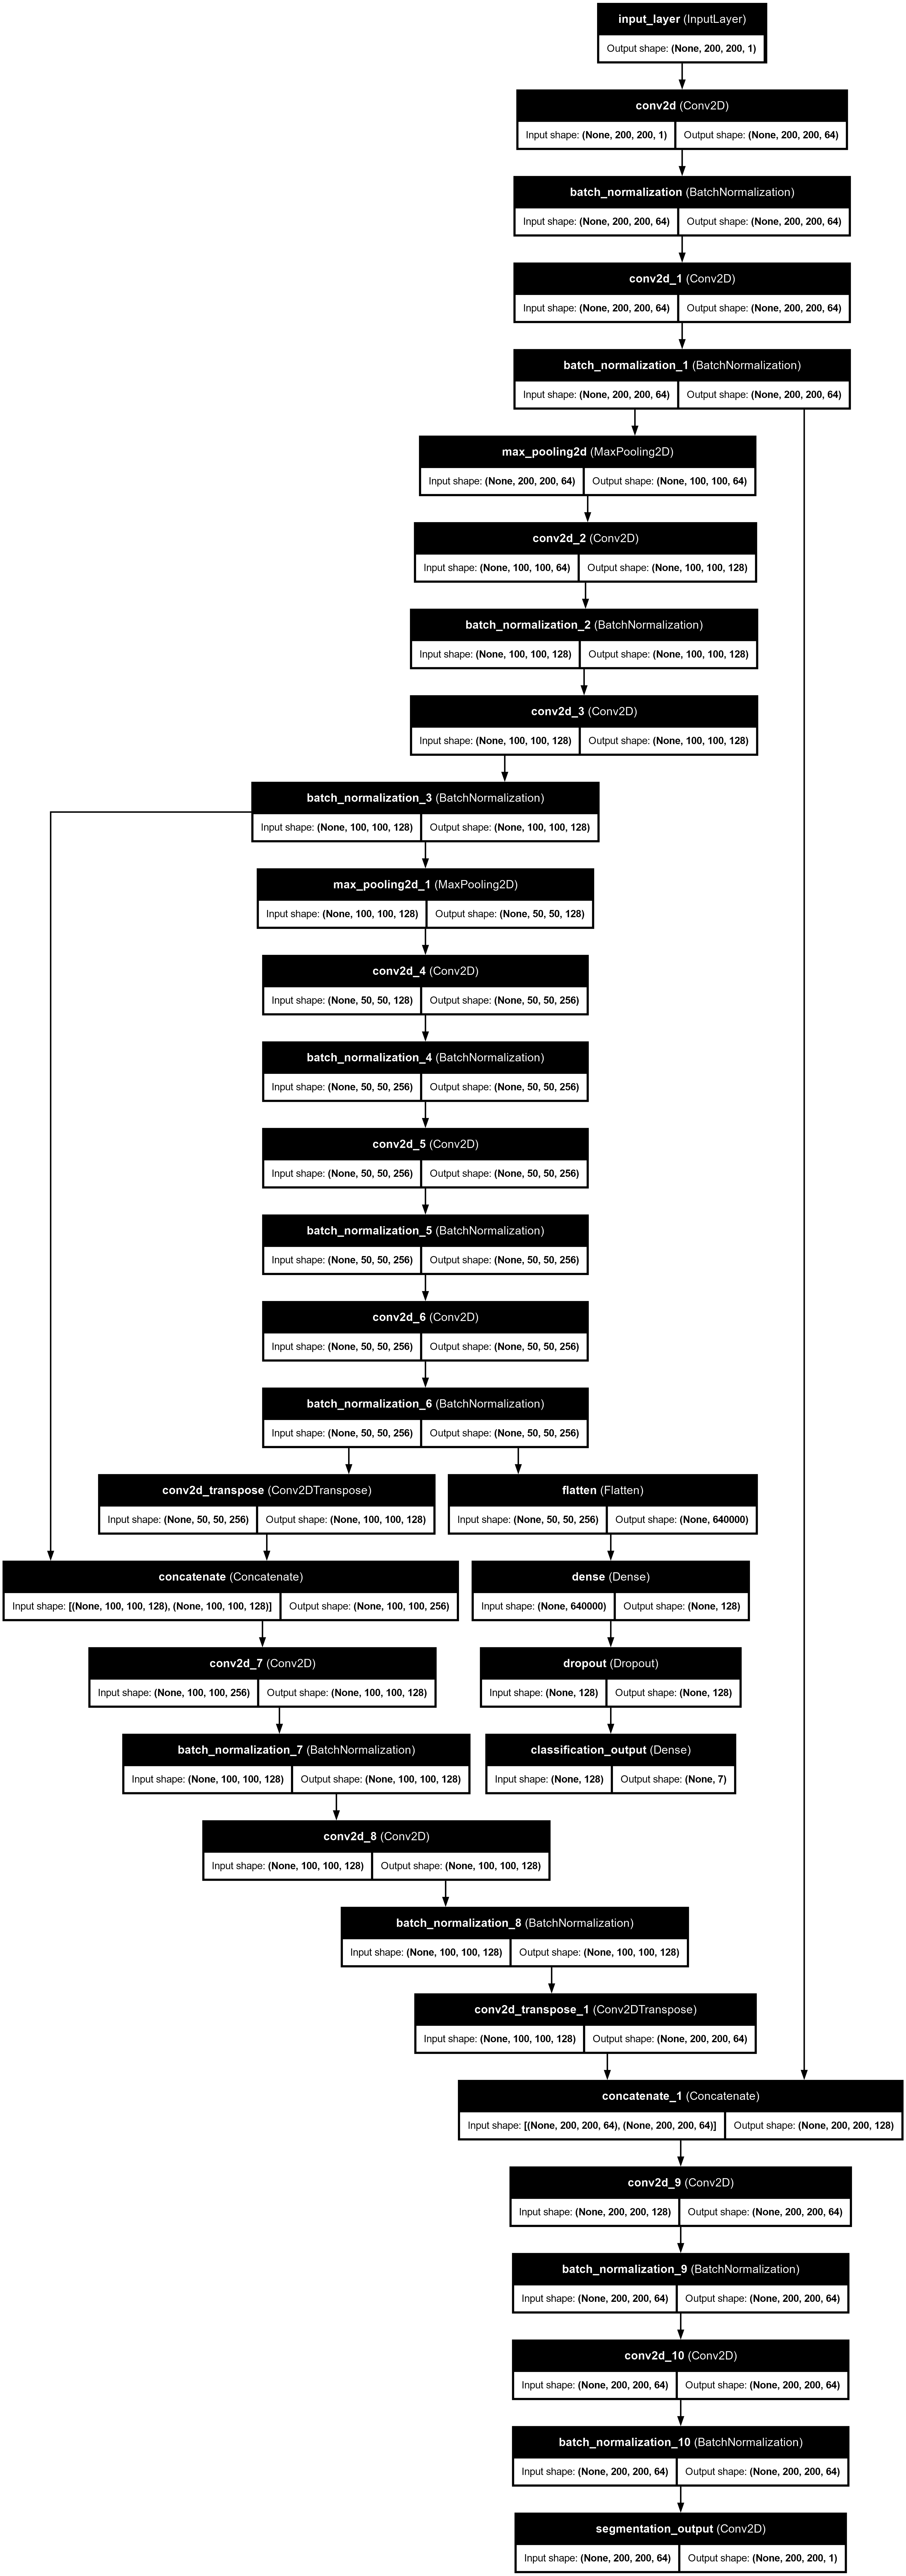

In [787]:
plot_model(model, to_file='elegant_unet_segmentation_classification.png', show_shapes=True, show_layer_names=True)

In [788]:
print("X_train_augmented shape:", x_train_filtered_images.shape)
print("y_train_augmented shape:", y_train_filtered_mask.shape)
print("y_train_categorical_augmented shape:", y_train_filtered_labels.shape)
print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_augmented:", y_train_filtered_labels.dtype)

X_train_augmented shape: (7000, 200, 200)
y_train_augmented shape: (7000, 200, 200)
y_train_categorical_augmented shape: (7000, 7)
Expected input shape for the model: (None, 200, 200, 1)
Model output shape: [(None, 200, 200, 1), (None, 7)]
Data type of y_train_augmented: float64


In [211]:
# Train the model
history = model.fit(x=x_train_filtered_images, 
                    y=[y_train_filtered_mask, y_train_filtered_labels],
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_test, [y_test_mask, y_test_class]),
                    callbacks=[ reduce_learning_rate, 
                                early_stopping, 
                                time_callback],
                    verbose=True)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1377s 6s/step - classification_output_accuracy: 0.1672 - classification_output_precision_2: 0.2663 - classification_output_recall_2: 0.0114 - loss: 1.1178 - segmentation_output_accuracy: 0.8588 - segmentation_output_mean_absolute_error: 0.3591 - val_classification_output_accuracy: 0.2000 - val_classification_output_precision_2: 0.0000e+00 - val_classification_output_recall_2: 0.0000e+00 - val_loss: 0.8736 - val_segmentation_output_accuracy: 0.9796 - val_segmentation_output_mean_absolute_error: 0.0717 - learning_rate: 0.0010
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1519s 7s/step - classification_output_accuracy: 0.2270 - classification_output_precision_2: 0.2305 - classification_output_recall_2: 0.0067 - loss: 0.8205 - segmentation_output_accuracy: 0.9805 - segmentation_output_mean_absolute_error: 0.0565 - val_classification_output_accuracy: 0.1429 - val_classification_output_precision_2: 0.0000e+00 - val_classification_output_recall_2: 0.0000e+00 

In [212]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_enhanced_unet_200.csv', index=False)
model.save('model_enhanced_unet_200.keras')
model.save('model_enhanced_unet_200.h5')